# Search Engine

## Imports

In [1]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
import json
import datetime
import pandas as pd
import collections
from collections import Counter
from collections import defaultdict
import csv
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as la
import time
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from array import array
import math
import operator

## Get Twitter API

In [2]:
## access token informations 
access_token1 = "1154413324605542402-Vw0b5pCK0Vtd8pRRQqTpqgR843fH8b"
access_token_secret1 = "u7tHOxEgwY16GmyvZ5CGRjT2u8TCh9dbF6ja24aguwsSR"

consumer_key1 = "xIryGomn5twiDnS9Cgs1fLQI1"
consumer_secret1 = "R8DdsPYy5f335yYu8RBC6NkZFl7H6AA6dBRdFBEZa8buSHd8Hj"

In [3]:
auth = OAuthHandler(consumer_key1, consumer_secret1)
auth.set_access_token(access_token1, access_token_secret1)
api = API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

## Scraping

In [4]:
class MyStreamListener(StreamListener):
    """
    Twitter listener, collects streaming tweets and output to a file
    """
    def __init__(self, api, OUTPUT_FILENAME, stop_condition=10):
        """
        initialize the stream, with num. of tweets and saving the outputfile
        """
        
        # this line is needed to import the characteristics of the streaming API
        super(MyStreamListener, self).__init__()
        
        # to-count the number of tweets collected        
        self.num_tweets = 0
        
        # save filename
        self.filename = OUTPUT_FILENAME
        
        # stop-condition
        self.stop_condition = stop_condition
        

    def on_status(self, status):
        
        """
        this function runs each time a new bunch of tweets is retrived from the streaming
        """
        
        with open(self.filename, "a+") as f:
            tweet = status._json
            
            f.write(json.dumps(tweet) + '\n')
            #self.output.append(tweet)
            self.num_tweets += 1
        
            # Stop condition        
            if self.num_tweets <= self.stop_condition:
                return True
            else:
                return False
        

    def on_error(self, status):
        """
        function useful to handle errors. It's possible to personalize it 
        depending on the way we want to handle errors
        """
        
        print(status)
        #returning False in on_error disconnects the stream
        return False

A strange error returned when trying to collect 100.000 tweets so we will divide the task of collecting them in two steps (50.000 and 50.000) and then merge the tweets.

In [5]:
%%time

OUTPUT_FILENAME = "data/one.json"
stop_condition = 50000

l = MyStreamListener(api, OUTPUT_FILENAME, stop_condition)
# here we recall the Stream Class from Tweepy to input the authentication info and our personalized listener 
stream = Stream(auth=api.auth, listener=l)

# keywords we may want decide to track 
TRACKING_KEYWORDS = ['pcr',"coronavirus", 'virus','covid']
stream.filter(
    track=TRACKING_KEYWORDS, 
    is_async=False, 
    languages = ["en"]
)

CPU times: user 1.03 s, sys: 367 ms, total: 1.4 s
Wall time: 27.3 s


In [6]:
%%time

OUTPUT_FILENAME = "data/two.json"
stop_condition = 50000

l = MyStreamListener(api, OUTPUT_FILENAME, stop_condition)
# here we recall the Stream Class from Tweepy to input the authentication info and our personalized listener 
stream = Stream(auth=api.auth, listener=l)

# keywords we may want decide to track 
TRACKING_KEYWORDS = ['SARS-CoV-2','lockdown', 'covid19','vaccine']
stream.filter(
    track=TRACKING_KEYWORDS, 
    is_async=False, 
    languages = ["en"]
)

500
CPU times: user 21.2 ms, sys: 3.62 ms, total: 24.8 ms
Wall time: 792 ms


In [7]:
with open("data/one.json", "rb") as f:
    data = f.readlines()
    data = [json.loads(str_) for str_ in data]

In [8]:
with open("data/two.json", "rb") as f:
    data2 = f.readlines()
    data2 = [json.loads(str_) for str_ in data2]

In [9]:
df_tweets = pd.DataFrame.from_records(data)
df_tweets2 = pd.DataFrame.from_records(data2)
tweets = [df_tweets,df_tweets2]
df_tweets = pd.concat(tweets)
df_tweets = df_tweets.drop_duplicates(subset='text', keep="last")

## Description of the data

In [ ]:
def print_retweets_and_likes(ID):
    retweets_ = df_tweets.at[ID,"retweeted_status"].apply(lambda x:0 if str(x)=='nan' else 1) 
    tot_retweets = sum(retweets_)
    unique_tweets = len(retweets_) - tot_retweets
    
    users_ = df_tweets.user.apply(lambda x:x['id'])
    
    tot_users = len(set(users_))
    
    print("Tot Retweets")
    print(tot_retweets)

    print("Unique Tweets")
    print(unique_tweets)
    
    print("Unique Users")
    print(tot_users)

In [ ]:
def print_retweets_uniqueTweets_uniqueUsers(df_tweets):
    retweets_ = df_tweets["retweeted_status"].apply(lambda x:0 if str(x)=='nan' else 1)
    tot_retweets = sum(retweets_)
    unique_tweets = len(retweets_) - tot_retweets
    
    users_ = df_tweets.user.apply(lambda x:x['id'])
    
    tot_users = len(set(users_))
    
    print("Tot Retweets")
    print(tot_retweets)

    print("Unique Tweets")
    print(unique_tweets)
    
    print("Unique Users")
    print(tot_users)

In [7]:
print_retweets_uniqueTweets_uniqueUsers(df_tweets)

Tot Retweets
41061
Unique Tweets
96158
Unique Users
105237


In [8]:
def extract_hashtags():

    hashtags_lists = df_tweets["entities"].apply(lambda x:x['hashtags']) 
    
    hashtags = hashtags_lists.apply(lambda x:x[0]['text'].lower() if x!= [] else None) 
    
    hashtags_by_frequency = Counter(hashtags) 
    hashtags_by_frequency = {k: hashtags_by_frequency[k] for k in hashtags_by_frequency if k!=None}
    
    return hashtags_by_frequency

In [9]:
hashtags_by_frequency = extract_hashtags()

In [10]:
df_hashtags = pd.DataFrame(hashtags_by_frequency.items())
df_hashtags.columns = ["hashtag", "count"]
df_hashtags.set_index("hashtag", inplace=True)
df_hashtags.sort_values("count", inplace=True, ascending=False)

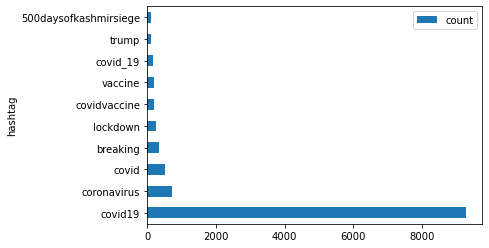

In [11]:
df_hashtags.head(10).plot.barh()
plt.show()

## Pre-processing the tweets

We have collected both an original tweet and all its retweets, but we have to use only the original ones. So we will first divide our tweets in unique and retweeted.

In [10]:
def getrts(df_tweets):
    retweets_ = df_tweets["retweeted_status"].apply(lambda x:0 if str(x)=='nan' else 1)
    return retweets_

In [11]:
#We recieve a list of 0 if tweet is unique and 1 if it is a retweet
retweets = getrts(df_tweets)
#We get the index of the retweets
retweets = retweets[retweets == 1]
retweets = retweets.index.values
#We now get df_unique which are the original tweets and df_retweeted which are the retweeted tweets
df_unique = df_tweets.drop(retweets,axis=0)
df_unique = df_unique.reset_index(drop=True)
df_retweeted = df_tweets.loc[retweets]
df_retweeted = df_retweeted[df_retweeted['retweeted_status'].notna()]
df_retweeted = df_retweeted.reset_index(drop=True)

Now we will change df_retweeted tweets by the original tweets they were retweeting

In [12]:
#We get common columns between the retweeted and the original tweets 
cols = df_retweeted.columns&df_retweeted.at[0,'retweeted_status'].keys()

for i in range(0,len(df_retweeted)):
    for col in cols:
        if col in df_retweeted.at[i,'retweeted_status'].keys():
            #Substitute the columns of the retweeted tweet by the original one
            #if col != 'possibly_sensitive':
            df_retweeted.at[i,col] = df_retweeted.at[i,'retweeted_status'][col]

Finally we will merge the two dataframes retweeted and unique

In [13]:
df_tweets = pd.concat([df_unique, df_retweeted], ignore_index=True)
df_tweets = df_tweets.drop_duplicates(subset=['id'])
df_tweets = df_tweets.reset_index(drop=True)

Now we will get the text of the tweets. When the tweet is long, we have to acces to it in 'extended_tweet' column in order to get all the words.

In [14]:
lines = [None]*len(df_tweets)
for i in range(0,len(df_tweets)):
    
    if type(df_tweets.at[i,'extended_tweet']) != float:
        lines[i] = df_tweets.at[i,'extended_tweet']['full_text']
    
    else:
        lines[i] = df_tweets.at[i,'text']

lines = [l.strip() for l in lines]

We will preprocess the tweets the following way:
- Removing Mentions and Links
- Removing stop-words 
- Removing punctuation 
- Stemming
- Delete hashtags
- Delete emojis

In [15]:
def remove_mentions(text):
    
    result = text.split()
    aux = text.split()
    for word in aux:
        if '@' in word:
            result.remove(word)
        elif 'https' in word:
            result.remove(word)
    result = ' '.join(result)
    
    return deEmojify(result)

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def delete_hashtags(text):
    
    result = text.split()
    aux = text.split()
    for word in aux:
        if '#' in word:
            result.remove(word)
    result = ' '.join(result)
    
    return result

In [16]:
def getTerms(line):
    
    #We remove mentions (@username) and links
    line = remove_mentions(line)
    #We remove Hashtags
    line = delete_hashtags(line)
    #We will get rid of RTs
    line= line.replace("RT ", "").strip()
    #We remove punctuations
    line=  line.lower() 
    line = re.sub(r'[^\w\s]','',line).strip()
    #We remove stop-words
    line=  line.split()
    stops = set(stopwords.words("english"))
    line=[word for word in line if word not in stops] 
    #Stemming
    stemming = PorterStemmer()
    line=[stemming.stem(word) for word in line] 
    
    return line

## Word Cloud

In [12]:
from wordcloud import WordCloud, ImageColorGenerator
STOPWORDS = stopwords.words('english')

In [13]:
bag_of_words = {}
for text in df_tweets["text"]:
    
    text = text.replace("RT ", "").strip()
    
    # lowering text
    text = text.lower()
    
    # removing all the punctuations
    text = re.sub(r'[^\w\s]','',text).strip()
    
    # tokenize the text
    lst_text = text.split()
    
    # remove stopwords
    lst_text = [x for x in lst_text if x not in STOPWORDS]
    
        
    # create bag-of-words - for each word the frequency of the word in the corpus
    for w in lst_text:
        if w not in bag_of_words:
            bag_of_words[w] = 0
        bag_of_words[w] +=1

In [53]:
aux = Counter(bag_of_words)
for k, v in aux.most_common(10):
     print (k,':',v)

covid19 : 23008
covid : 17977
vaccine : 14886
lockdown : 13703
people : 6598
get : 4810
new : 4695
amp : 4464
coronavirus : 4383
us : 4382


In [54]:
aux = pd.DataFrame.from_dict(aux, orient='index').reset_index()
aux = aux.rename(columns = {'index':'word',0:'count'})
aux.set_index("word", inplace=True)
aux.sort_values('count', inplace=True, ascending=False)

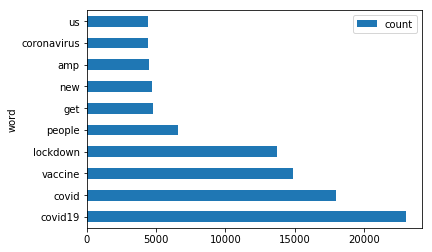

In [55]:
aux.head(10).plot.barh()
plt.show()

## Building search engines

We will built two search engines based on different ways of ranking. One using the classical TF-IDF and the other based on the popularity of the tweet (likes and retweets).

In [17]:
def create_index_tfidf(lines, numDocuments):
        
    index=defaultdict(list)
    
    #Term frequencies of terms in documents (tweets)
    tf=defaultdict(list) 
    
    #Document (tweet) frequencies of terms in the corpus
    df=defaultdict(int)         
    
    #Inverse document (tweet) frequencies
    idf=defaultdict(float)
    
    #Count we will use to assign IDs to tweets
    count = 0
    
    for line in lines:
        
        tweet_id = count
        
        #We get the terms of the tweet
        terms = getTerms(line)                     
        termdictPage={}

        for position, term in enumerate(terms): 
            try:
                #If the term is already in the dict append the position to the corrisponding list
                termdictPage[term][1].append(position) 
            except:
                #Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term]=[tweet_id, array('I',[position])]
        
        #Normalize term frequencies. Norm is the same for all terms of a document.
        norm=0
        for term, posting in termdictPage.items(): 
            norm+=len(posting[1])**2
        norm=math.sqrt(norm)
        
        #Calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in termdictPage.items():     
            tf[term].append(np.round(len(posting[1])/norm,4))  
            df[term] += 1
        
        #Merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage)
        
        count += 1
    
    #Compute idf
    for term in df:
        idf[term] = np.round(np.log(float(numDocuments/df[term])),4)
           
    return index, tf, df, idf

Create index

In [18]:
start_time = time.time()
numDocuments = len(lines)
index, tf, df, idf = create_index_tfidf(lines, numDocuments)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))

Total time to create the index: 97.05 seconds


We will now define the functions to rank tweets

In [19]:
def rankDocuments(terms, docs, index, idf, tf):
        
    #We are interested only on the element of the docVector corresponding to the query terms, so remaining elemnts
    #would became 0 when multiplied to the queryVector
    docVectors=defaultdict(lambda: [0]*len(terms)) 
    queryVector=[0]*len(terms)    
    
    #Get frequency of each term in the query
    query_terms_count = collections.Counter(terms)  
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): 
        if term not in index:
            continue
            
        #Compute tf*idf
        queryVector[termIndex]=query_terms_count[term]/query_norm * idf[term] 
        
        # Generate docVectors for matching docs
        for docIndex, (doc, postings) in enumerate(index[term]):
            if doc in docs:
                docVectors[doc][termIndex]=tf[term][docIndex] * idf[term]  # Check if multiply for idf
    
    #Calculate the score of each doc computing cosine similarity between queryVector and each docVector
    docScores=[ [np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items() ]
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    
    if len(resultDocs) == 0:
        print("No results found")
        
    return resultDocs

In [20]:
def rankDocuments_Popularity(docs, likes, rts, verified):
    
    #Each tweet will have a score based on its popularity
    popularity=defaultdict(list)
    
    for i in docs:
        #The score for each tweet will be computed by the number of retweets plus half the count of likes
        popularity[i] = (likes[i]/2)+rts[i]
        #If the user is verified the popularity is popularity score is duplicated
        if verified[i] == True:
            popularity[i] = 2*popularity[i]
        
    #Sort the tweets by popularity
    sorted_popularity = dict( sorted(popularity.items(), key=operator.itemgetter(1),reverse=True))
    resultDocs = list(sorted_popularity.keys())
    
    if len(resultDocs) == 0:
        print("No results found")   

    return resultDocs

Search functions

In [21]:
def search_tf_idf(query, index):
    
    #Get terms of the query
    query=getTerms(query)
    docs=set()
    
    #Count will help us to avoid a problem when doing instersection
    count = 0
    
    for term in query:
        try:
            #Store in termDocs the ids of the docs that contain "term"
            termDocs=[posting[0] for posting in index[term]]
            
            #As tweet must contain ALL word in query docs = docs Instersection termDocs
            if count == 0:
                docs |= set(termDocs)
                count += 1
            else:
                docs &= set(termDocs)
        except:
            #Term not in index
            pass
        
    docs=list(docs)
    #We rank documents with TF-IDF
    ranked_docs = rankDocuments(query, docs, index, idf, tf) 
    
    return ranked_docs

In [22]:
def search_popularity(query, index):
    
    #Get terms of the query
    query=getTerms(query)
    docs=set()
    
    #Store likes, retweets and if the user is verified for each tweet
    likes=defaultdict(list)
    rts=defaultdict(list)
    verified=defaultdict(list)
    
    #Count will help us to avoid a problem when doing instersection
    count = 0
    
    for term in query:
        try:
            #Store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            #As tweet must contain ALL word in query docs = docs Instersection termDocs
            if count == 0:
                docs |= set(termDocs)
                count += 1
            else:
                docs &= set(termDocs)
        except:
            #term is not in index
            pass
        
    docs=list(docs)
    
    #We store likes and retweets for each tweet
    for i in docs:
        likes[i] = df_tweets.at[i,'favorite_count']
        rts[i] = df_tweets.at[i,'retweet_count']
        verified[i] = df_tweets.at[i,'user']['verified']
        
    #We rank documents by popularity
    ranked_docs = rankDocuments_Popularity(docs, likes, rts,verified)  
    
    return ranked_docs

In [23]:
def nolinks(text):
    text = text.split()
    aux = text.copy()
    for word in aux:
        if 'https' in word:
            text.remove(word)
    text = ' '.join(text)
    return text

## Compile search engine

We define a function to print the top tweets returned from our search engine. The final output of a query must return (when present) the following information for each of the selected documents: 
- Tweet
- Username
- Date
- Hashtags
- Likes
- Retweets
- Url

In [26]:
def PrintTweets(ranked_docs,top):
    
    print("\n======================\nTop {} results out of {} for the seached query:\n".format(top, len(ranked_docs)))
    count = 0
    for d_id in ranked_docs[:top] :
        
        print('Result number:',count+1,'\n')

        if type(df_tweets.at[d_id,'extended_tweet']) == float:
            print('Tweet: ',nolinks(df_tweets.at[d_id,'text']))
        else:
            print('Tweet: ',nolinks(df_tweets.at[d_id,'extended_tweet']['full_text']))

        print('\nUsername: ',df_tweets.at[d_id,'user']['screen_name'])

        print('\nDate: ',time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(df_tweets.at[d_id,'created_at'],'%a %b %d %H:%M:%S +0000 %Y')))

        if df_tweets.at[d_id,"entities"]['hashtags'] != []:
            hashs = [None]*len(df_tweets.at[d_id,"entities"]['hashtags'])
            for i in range(0,len(df_tweets.at[d_id,"entities"]['hashtags'])):
                hashs[i] = df_tweets.at[d_id,"entities"]['hashtags'][i]['text']
            print('\nHashtags: ',hashs)
        else:
            print('\nHashtags: None')

        print('\nLikes: ',df_tweets.at[d_id,'favorite_count'])

        print('\nRetweets: ',df_tweets.at[d_id,'retweet_count'])

        print('\nURL: https://twitter.com/twitter/statuses/'+str(df_tweets.at[d_id,'id']))

        print('\n----------------------\n')
        count += 1

In [28]:
aux = 0

while(aux==0):
    
    print("Choose way of ranking:\n1. TF-IDF\n2. POPULARITY")
    mode = input()
    
    if mode == str(1):
        aux += 1
        
    elif mode == str(2):
        aux += 1
        
    else:
        print('\nEntry not valid, try again.\n')

print("Insert your query:\n")
query = input()
top = 20

if mode == str(1):
    ranked_docs = search_tf_idf(query, index)    
    PrintTweets(ranked_docs,top)

elif mode == str(2):
    ranked_docs = search_popularity(query,index)
    PrintTweets(ranked_docs,top)

Choose way of ranking:
1. TF-IDF
2. POPULARITY
1
Insert your query:

Lockdown is boring

Top 20 results out of 44 for the seached query:

Result number: 1 

Tweet:  BORED! Bored with work Bored with Lockdown (1,2 &amp; 3) Bored with PC nonces Bored with cyclists Bored with yes men Bored with Brexit Bored with politicians (all of them) Bored with everything Crave change... Want alcohol 🍺 Want sunshine ☀️ Want somewhere else!

Username:  PFSClassics

Date:  2020-12-17 20:42:15

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339672275415674882

----------------------

Result number: 2 

Tweet:  Who else is bored of lockdown????????

Username:  HannahTompkins

Date:  2020-12-17 20:57:35

Hashtags: None

Likes:  0

Retweets:  0

URL: https://twitter.com/twitter/statuses/1339676137803423746

----------------------

Result number: 3 

Tweet:  @bethwatt27 Lockdown and tv is boring lol.

Username:  TheBigM32122247

Date:  2020-12-17 22:04:12

Hashtags: None
